<a href="https://colab.research.google.com/github/C3578/Cell_detection/blob/master/Cell_detection_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

На фотографиях изображены клетки нервной системы. Клетка состоит из ядра и может иметь до нескольких отростков (нейритов), или не иметь их. Ядро на картинке - это центральная яркая часть клетки.

Написать алгоритм, который будет

1) находить клетки как координаты их (примерных) центров

2) находить усы как пиксельную 

3) определять клетку-владельца каждого уса и нарисовать их разными цветами

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import random

from tqdm import tqdm

In [0]:
from google.colab.patches import cv2_imshow

In [0]:
img_1 = cv2.imread('gdrive/My Drive/reml/input.png')
img_2 = cv2.imread('gdrive/My Drive/reml/1.png')
img_3 = cv2.imread('gdrive/My Drive/reml/2.png')
img_4 = cv2.imread('gdrive/My Drive/reml/3.png')

In [0]:
bc = 80       # отсечка по яркости для клеток и около клеточного пространства
m_len = 250   # минимальная длина уса
min_cell = 20 # минимальный размер клетки

In [0]:
def show(img):
  cv2_imshow(img)
  cv2.waitKey(0)
  cv2.destroyAllWindows() 

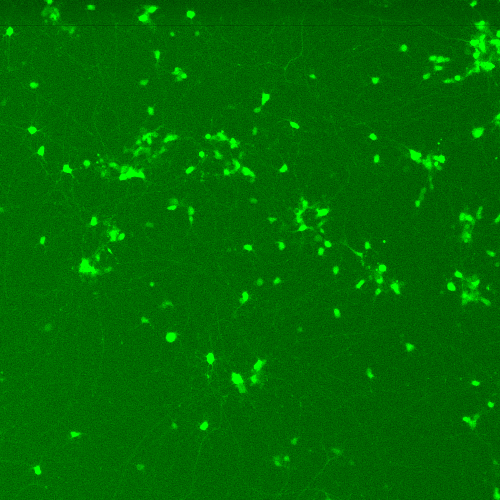

In [0]:
show(img_1)

# Строим обходчик усов

Обходчик стартует с самой яркой точки контура найденной клетки и устремляется в зону максимальной яркости, но не уходит на площадь самой клетки так как вся площадь клетки кроме ее границы затемнена.

In [0]:
#Данная функция возвращает среднюю яркость 9 пикселей(1, 3, 5) по направлению функции(up, down, left, right).
def up(y, x, img, n=3):
  if img[y][x] == 0:
    return 0

  else:

    list1 = []
    m = 0
    for i in range(y-1, y-n-1, -1):

      m += 1
      for j in range(x-m, x+m+1):

        list1 += [img[i][j]]

    return np.mean(list1)

In [0]:
#Данная функция возвращает среднюю яркость 9 пикселей(1, 3, 5) по направлению функции(up, down, left, right).
def down(y, x, img, n=3):
  if img[y][x] == 0:
    return 0

  else:

    list1 = []
    m = 0
    for i in range(y+1, y+n+1):

      m += 1
      for j in range(x-m, x+m+1):

        list1 += [img[i][j]]

    return np.mean(list1)

In [0]:
#Данная функция возвращает среднюю яркость 9 пикселей(1, 3, 5) по направлению функции(up, down, left, right).
def left(y, x, img, n=3):
  if img[y][x] == 0:
    return 0
    
  else:

    list1 = []
    m = 0
    for j in range(x-1, x-n-1, -1):
      
      m += 1
      for i in range(y-m, y+m+1):
        
        list1 += [img[i][j]]

    return np.mean(list1)

In [0]:
#Данная функция возвращает среднюю яркость 9 пикселей(1, 3, 5) по направлению функции(up, down, left, right).
def right(y, x, img, n=3):
  if img[y][x] == 0:
    return 0

  else:
    list1 = []
    m = 0
    for j in range(x+1, x+n+1):
      m += 1
      for i in range(y-m, y+m+1):
        list1 += [img[i][j]]

    return np.mean(list1)

In [0]:
# Определяет в каком направление яркость максимальная и возвращает код этого направления()
# Если по всем направлениям значения яркости меньше установленного порога яркости max1
# то возвращается код 5
def step(y, x, img, max1):
  d = np.array([up(y, x, img), down(y, x, img), left(y, x, img), right(y, x, img)])

  if max(d) > max1:
    return np.where(d == max(d))[0]

  else:
    return [5]

In [0]:
# Рекурсивная функция, которая шагает в выбранном направление и там вызывает сама себя.
def trackman(y, x, img, max1):
  global track
  global d
  
  for i in d:
  
    if i == 5 or y < 5 or y > (img.shape[0]-4) or x < 5 or x > (img.shape[1]-4):
      return
    
    else:

      d = step(y, x, img, max1)
      #print(d)
      img[y][x] = 0
      track += [[y, x]]
      #print(y, x)

      if 0 in d:
        trackman(y-1, x, img, max1)
                
      if 1 in d:
        trackman(y+1, x, img, max1)

      if 2 in d:
        trackman(y, x-1, img, max1)

      if 3 in d:
        trackman(y, x+1, img, max1)

In [0]:
def detect_cm(img, bc=bc, min_cell=min_cell):

  global circles, contours, contours_2, gray

  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  # определяем самые яркие области, там будут наши клетки.
  ret, thresh = cv2.threshold(gray, bc, 255, cv2.THRESH_BINARY_INV) #  bc порог яркости клетки
    
  backup = thresh.copy()

  # находим контуры наших клеток
  _, contours, _ = cv2.findContours(backup, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
  circles = {} # словарь с координатами наших кругов.
  contours_2 = []

  for i, contour in enumerate(contours):
      
    x, y, w, h = cv2.boundingRect(contour) # прямоугольник вокруг клетки

    # Если площадь меньше минимальной границе, то эта клетка не учитывается
    if 5000 > cv2.contourArea(contour) > min_cell:

      contours_2 += [contour]

      circle = [x + (w//2), y + (h//2), max([w, h])//2+5]

      circles[i] = circle

      #cv2.circle(backup, (circle[0], circle[1]), circle[2], (0, 255, 0), 1)

Функция detect возвращает gray-изображение на котором обнаруженные клетки, обведены кружочком, и принадлежащие данной клетки усы отмечены таким же цветом.

In [0]:
def detect(img, bc=bc, m_len=m_len, min_cell = min_cell):
  global tracklist, d, track
  
  detect_cm(img, bc=bc, min_cell=min_cell)
  gray_2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  

  gray_2[np.where(gray_2 > bc)] = 0   # затемнение клеток и около клеточного пространства

  # Окрашиваем контуры клеток в среднее значение по яркости
  for contour in contours:
    for i in contour:
      gray_2[i[0][1]][i[0][0]] = gray.mean()

  gray = gray_2.copy()

  tracklist=[]

  #gray = cv2.GaussianBlur(gray,(3,3),1)

  for contour in tqdm(contours_2):
    track =[]
    for x in contour:
      for i,j in x:
        d = [6]
        trackman(j, i, gray, gray.mean())
    tracklist += [track]
    #print(tracklist)

  img_3 = img.copy()

  for i in img_3:
    for j in i:
      j[0]=j[1]
      j[2]=j[1]

  count = 0

  for x in circles:
    R = random.randrange(0, 255, 1)
    G = random.randrange(0, 255, 1)
    B = random.randrange(0, 255, 1)

    cv2.circle(img_3, (circles[x][0], circles[x][1]), circles[x][2], (R, G, B), 2)

    for i, j in tracklist[count]:
      if len(tracklist[count])> m_len:
        img_3[i][j] = (R, G, B)
    count += 1

  cv2_imshow(img_3)
  cv2.waitKey(0)
  cv2.destroyAllWindows() 

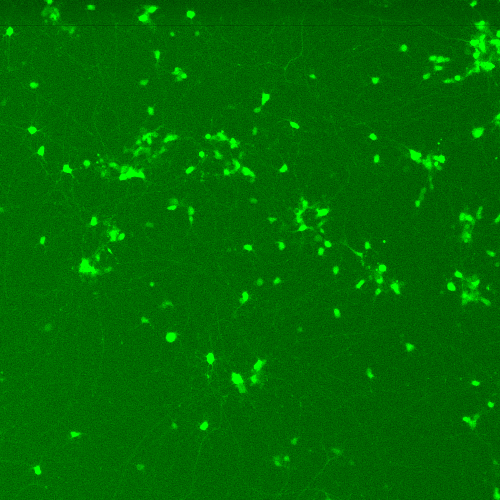

In [0]:
show(img_1)

100%|██████████| 112/112 [00:05<00:00, 21.17it/s]


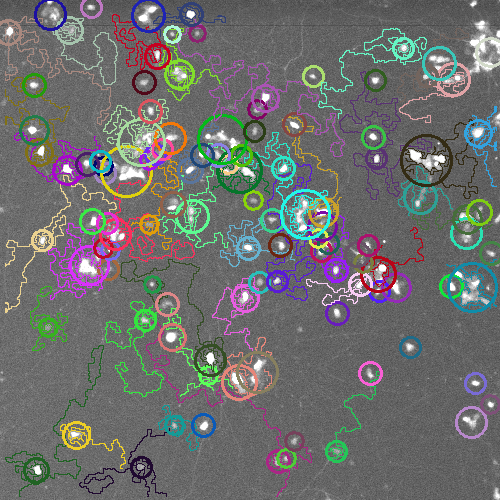

In [0]:
detect(img_1)

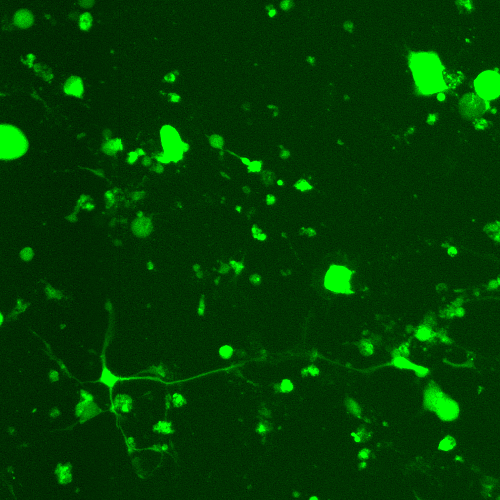

100%|██████████| 31/31 [00:01<00:00, 28.63it/s]


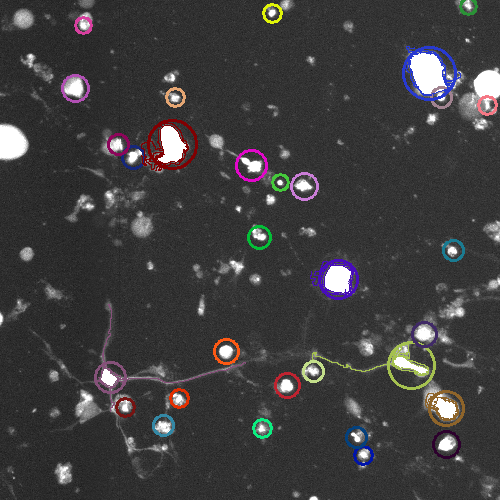

In [0]:
show(img_2)
detect(img_2, bc = 149)

In [0]:
bc = 80       # отсечка по яркости для клеток и около клеточного пространства
m_len = 250   # минимальная длина уса
min_cell = 20 # минимальный размер клетки

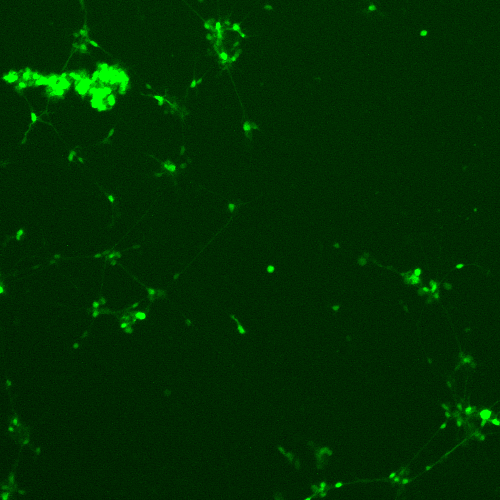

100%|██████████| 73/73 [00:03<00:00, 22.88it/s]


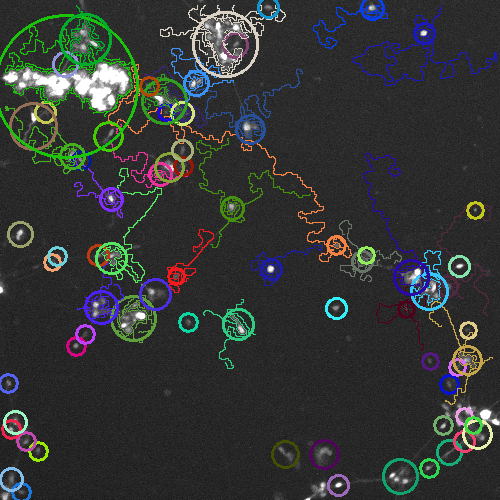

In [0]:
show(img_3)
detect(img_3, bc =40, min_cell = 10 )

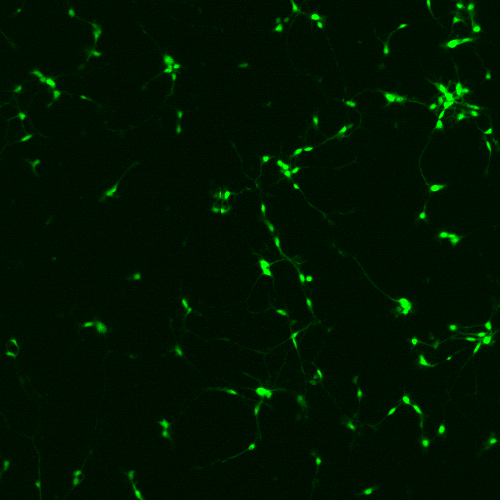

100%|██████████| 82/82 [00:01<00:00, 44.69it/s]


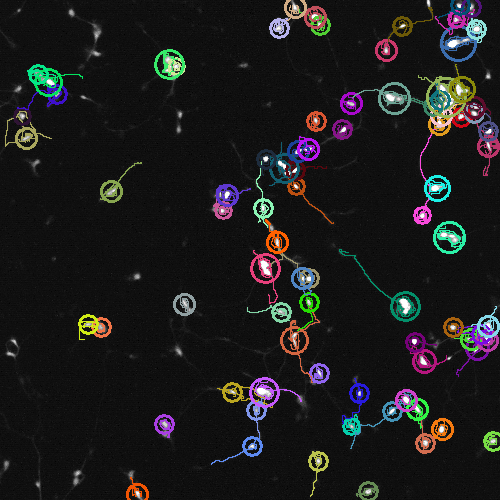

In [0]:
show(img_4)
detect(img_4, m_len = 50)

In [0]:
# tracklist маски всех усов
# circles словарь с координатами центров всех клеток